In [201]:
# Business Problem:
# A marketing team is spending budget sending campaigns to ALL customers equally.
# This project answers:
# - Who are our best customers?
# - Who is about to leave?
# - Where should we spend our retention budget?
# - Who is NOT worth spending money on?

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    silhouette_score
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [203]:
dataurl = r"D:\Python Codes\marketing_campaign.xlsx" 
df = pd.read_excel(dataurl)

print(f"Shape: {df.shape}")
print(f"\nColumn names:\n{list(df.columns)}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst 3 rows:")
df.head()

Shape: (2240, 29)

Column names:
['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']

Data types:
ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPur

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [204]:
#Check Data Quality
# Nulls in Income would corrupt RFM monetary calculation. Duplicates would double-count customers and inflate segment sizes
print("=== DATA QUALITY CHECK ===")
print(f"\nShape: {df.shape}")
print(f"\nNull values per column:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print(f"\nDuplicate rows: {df.duplicated().sum()}")
print(f"\nBasic statistics:")
df.describe().round(2)


=== DATA QUALITY CHECK ===

Shape: (2240, 29)

Null values per column:
Income    24
dtype: int64

Duplicate rows: 0

Basic statistics:


,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.00,2240.00,2216.00,2240.00,2240.00,2240.00,2240.00,2240.00,2240.00,2240.00,...,2240.00,2240.00,2240.00,2240.00,2240.00,2240.00,2240.00,2240.0,2240.0,2240.00
mean,5592.16,1968.81,52247.25,0.44,0.51,49.11,303.94,26.30,166.95,37.53,...,5.32,0.07,0.07,0.07,0.06,0.01,0.01,3.0,11.0,0.15
std,3246.66,11.98,25173.08,0.54,0.54,28.96,336.60,39.77,225.72,54.63,...,2.43,0.26,0.26,0.26,0.25,0.11,0.10,0.0,0.0,0.36
min,0.00,1893.00,1730.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.0,11.0,0.00
25%,2828.25,1959.00,35303.00,0.00,0.00,24.00,23.75,1.00,16.00,3.00,...,3.00,0.00,0.00,0.00,0.00,0.00,0.00,3.0,11.0,0.00
50%,5458.50,1970.00,51381.50,0.00,0.00,49.00,173.50,8.00,67.00,12.00,...,6.00,0.00,0.00,0.00,0.00,0.00,0.00,3.0,11.0,0.00
75%,8427.75,1977.00,68522.00,1.00,1.00,74.00,504.25,33.00,232.00,50.00,...,7.00,0.00,0.00,0.00,0.00,0.00,0.00,3.0,11.0,0.00
max,11191.00,1996.00,666666.00,2.00,2.00,99.00,1493.00,199.00,1725.00,259.00,...,20.00,1.00,1.00,1.00,1.00,1.00,1.00,3.0,11.0,1.00


In [205]:
#Data Cleaning
# Q: Why drop Z_CostContact and Z_Revenue?
# A: exact same value, A column with zero variance adds zero information to any model.
print("=== BEFORE CLEANING ===")
print(f"Shape: {df.shape}")

# Drop constant columns — zero variance, zero value
df.drop(columns=["Z_CostContact", "Z_Revenue"], inplace=True)

# Drop duplicates
df.drop_duplicates(inplace=True)

# Drop nulls (only ~24 rows with null Income)
df.dropna(inplace=True)

print(f"\n=== AFTER CLEANING ===")
print(f"Shape: {df.shape}")
print(f"Rows removed: {2240 - len(df)}")

=== BEFORE CLEANING ===
Shape: (2240, 29)

=== AFTER CLEANING ===
Shape: (2216, 27)
Rows removed: 24


In [206]:
#Feature Engineering — Part 1 (Combining Columns)

#Combined features map to real business concepts stakeholders actually talk about and make decisions with. Total purchase count is what drives Frequency in RFM.

# Total spend across all product categories
df["MntTotalExpense"] = (
    df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] +
    df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]
)
df.drop(columns=["MntWines","MntFruits","MntMeatProducts",
                  "MntFishProducts","MntSweetProducts","MntGoldProds"],
        inplace=True)

# Total purchases across all channels
df["TotalPurchases"] = (
    df["NumDealsPurchases"] + df["NumWebPurchases"] +
    df["NumCatalogPurchases"] + df["NumStorePurchases"]
)
df.drop(columns=["NumDealsPurchases","NumWebPurchases",
                  "NumCatalogPurchases","NumStorePurchases"],
        inplace=True)

# Total campaign acceptances
df["AcceptedCmp_Total"] = (
    df["AcceptedCmp1"] + df["AcceptedCmp2"] + df["AcceptedCmp3"] +
    df["AcceptedCmp4"] + df["AcceptedCmp5"]
)
df.drop(columns=["AcceptedCmp1","AcceptedCmp2","AcceptedCmp3",
                  "AcceptedCmp4","AcceptedCmp5"],
        inplace=True)

print("Combined features created:")
print(f"  MntTotalExpense — range: ${df['MntTotalExpense'].min()} to ${df['MntTotalExpense'].max()}")
print(f"  TotalPurchases  — range: {df['TotalPurchases'].min()} to {df['TotalPurchases'].max()}")
print(f"  AcceptedCmp_Total — range: {df['AcceptedCmp_Total'].min()} to {df['AcceptedCmp_Total'].max()}")
df.head(3)

Combined features created:
  MntTotalExpense — range: $5 to $2525
  TotalPurchases  — range: 0 to 44
  AcceptedCmp_Total — range: 0 to 4


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,NumWebVisitsMonth,Complain,Response,MntTotalExpense,TotalPurchases,AcceptedCmp_Total
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,7,0,1,1617,25,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,5,0,0,27,6,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,4,0,0,776,21,0


In [207]:
#Feature Engineering — Part 2 (New Features)

# Year_Birth (1957) is not interpretable as a feature. Age (67) is. Models and stakeholders both understand age.

df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])
df["Age"] = 2024 - df["Year_Birth"]
df["CustomerTenure_Days"] = (
    df["Dt_Customer"].max() - df["Dt_Customer"]
).dt.days

# Family status — binary flag
df["HasChildren"] = (
    (df["Kidhome"] + df["Teenhome"]) > 0
).astype(int)

print("New features created:")
print(f"  Age — range: {df['Age'].min()} to {df['Age'].max()} years")
print(f"  CustomerTenure_Days — range: {df['CustomerTenure_Days'].min()} to {df['CustomerTenure_Days'].max()} days")
print(f"  HasChildren — {df['HasChildren'].sum()} customers with children ({df['HasChildren'].mean()*100:.1f}%)")

# NOW drop these
df.drop(columns=["Year_Birth", "Dt_Customer",
                  "Education", "Marital_Status"],
        inplace=True)

print(f"\nShape after all feature engineering: {df.shape}")
df.head()

New features created:
  Age — range: 28 to 131 years
  CustomerTenure_Days — range: 0 to 699 days
  HasChildren — 1583 customers with children (71.4%)

Shape after all feature engineering: (2216, 14)


,ID,Income,Kidhome,Teenhome,Recency,NumWebVisitsMonth,Complain,Response,MntTotalExpense,TotalPurchases,AcceptedCmp_Total,Age,CustomerTenure_Days,HasChildren
0,5524,58138.0,0,0,58,7,0,1,1617,25,0,67,663,0
1,2174,46344.0,1,1,38,5,0,0,27,6,0,70,113,1
2,4141,71613.0,0,0,26,4,0,0,776,21,0,59,312,0
3,6182,26646.0,1,0,26,6,0,0,53,8,0,40,139,1
4,5324,58293.0,1,0,94,5,0,0,422,19,0,43,161,1


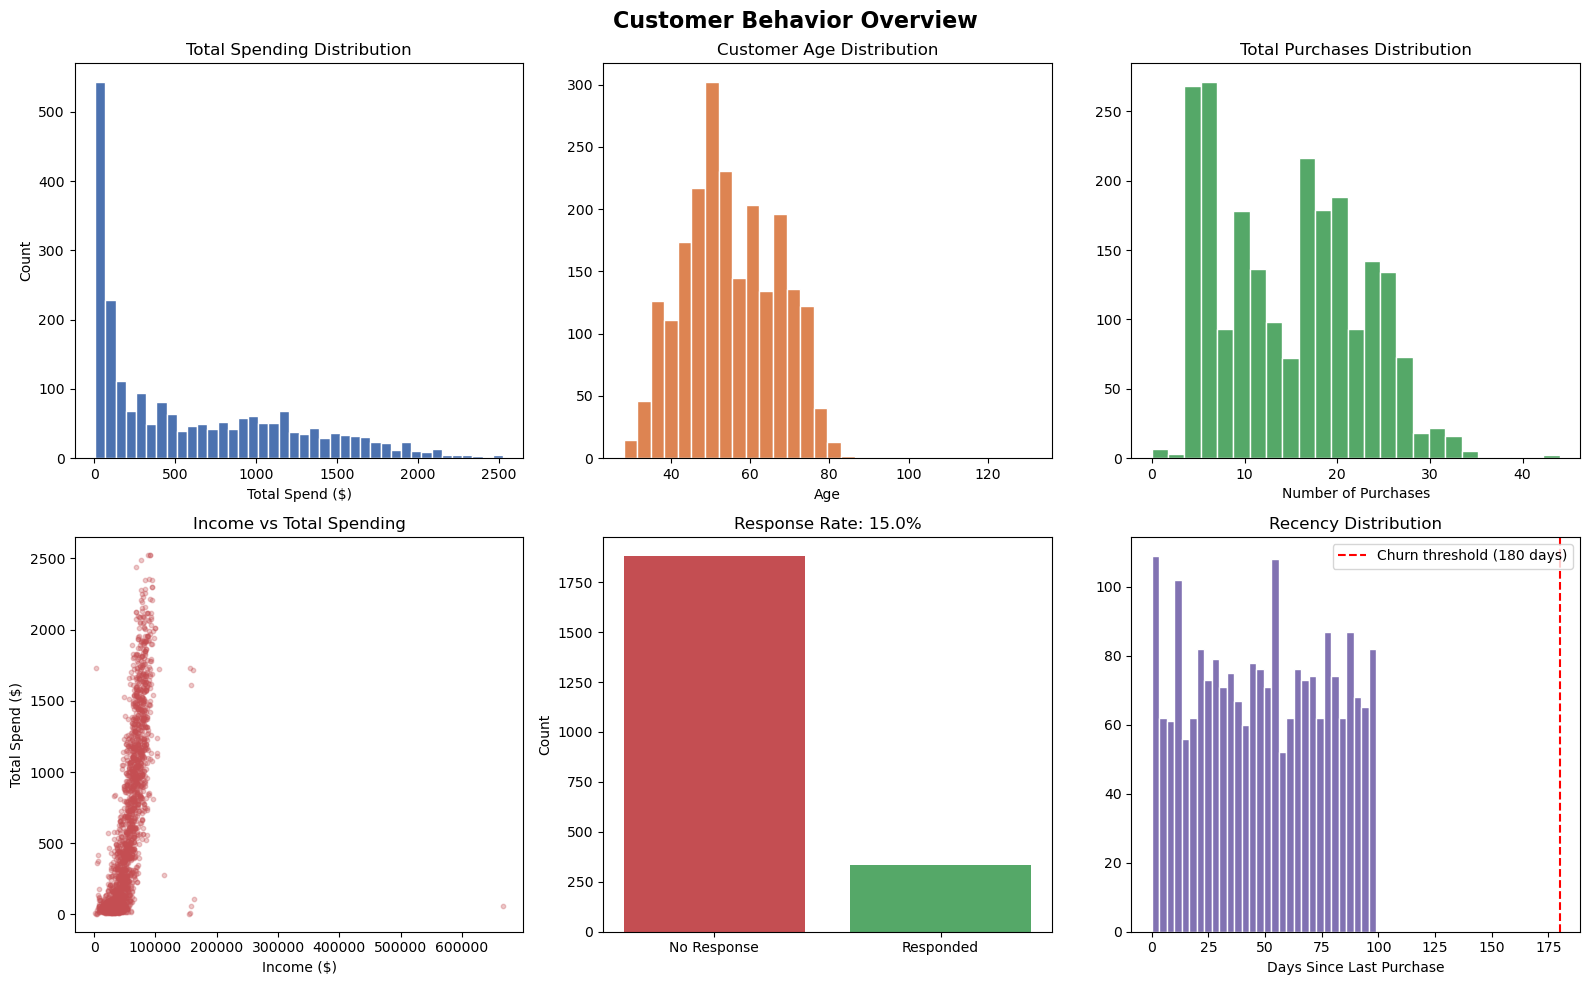

In [208]:
#Exploratory Data Analysis
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle("Customer Behavior Overview", fontsize=16, fontweight="bold")

# Total spend distribution
axes[0,0].hist(df["MntTotalExpense"], bins=40, color="#4C72B0", edgecolor="white")
axes[0,0].set_title("Total Spending Distribution")
axes[0,0].set_xlabel("Total Spend ($)")
axes[0,0].set_ylabel("Count")

# Age distribution
axes[0,1].hist(df["Age"], bins=30, color="#DD8452", edgecolor="white")
axes[0,1].set_title("Customer Age Distribution")
axes[0,1].set_xlabel("Age")

# Purchase frequency
axes[0,2].hist(df["TotalPurchases"], bins=25, color="#55A868", edgecolor="white")
axes[0,2].set_title("Total Purchases Distribution")
axes[0,2].set_xlabel("Number of Purchases")

# Income vs Spending
axes[1,0].scatter(df["Income"], df["MntTotalExpense"],
                  alpha=0.3, color="#C44E52", s=10)
axes[1,0].set_title("Income vs Total Spending")
axes[1,0].set_xlabel("Income ($)")
axes[1,0].set_ylabel("Total Spend ($)")

# Campaign response rate
response_counts = df["Response"].value_counts()
axes[1,1].bar(["No Response", "Responded"],
              response_counts.values,
              color=["#C44E52", "#55A868"])
axes[1,1].set_title(f"Response Rate: {df['Response'].mean()*100:.1f}%")
axes[1,1].set_ylabel("Count")

# Recency distribution
axes[1,2].hist(df["Recency"], bins=30, color="#8172B2", edgecolor="white")
axes[1,2].axvline(x=180, color="red", linestyle="--", label="Churn threshold (180 days)")
axes[1,2].set_title("Recency Distribution")
axes[1,2].set_xlabel("Days Since Last Purchase")
axes[1,2].legend()

plt.tight_layout()
#plt.savefig("eda_overview.png", dpi=150, bbox_inches="tight")
plt.show()
#print("Saved: eda_overview.png")

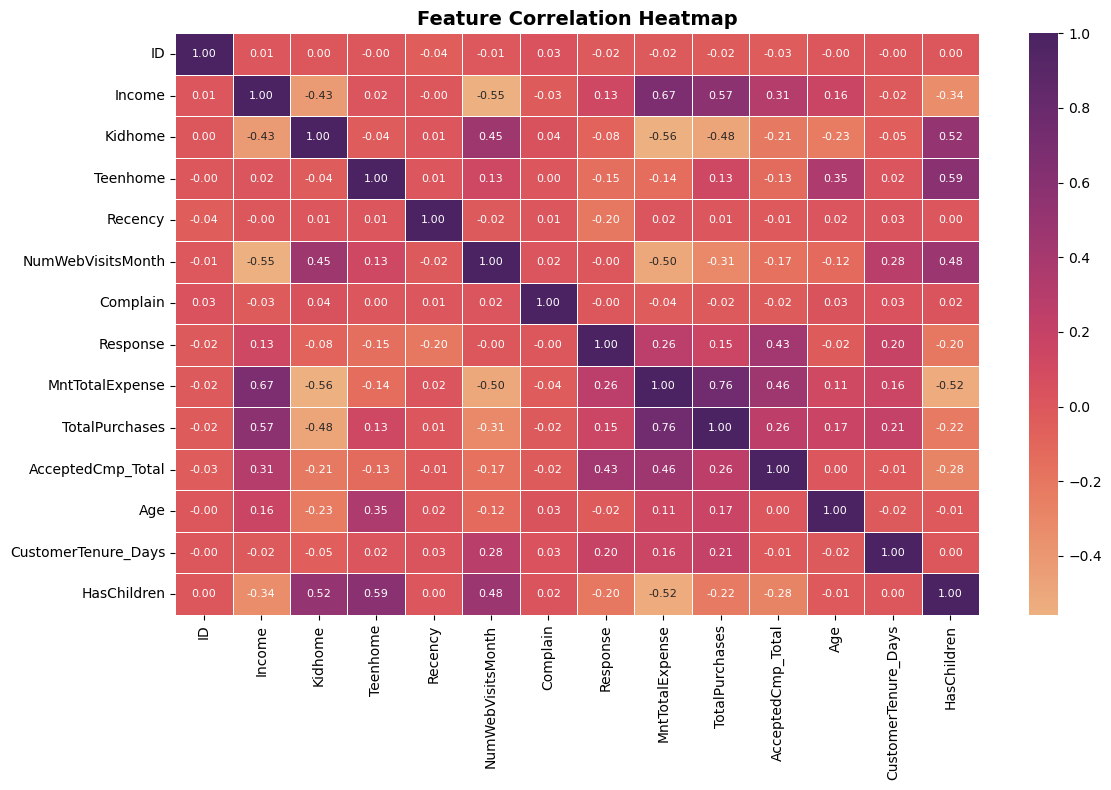


Top correlations with Response (target variable):
AcceptedCmp_Total      0.427
MntTotalExpense        0.264
HasChildren           -0.204
Recency               -0.200
CustomerTenure_Days    0.196
TotalPurchases         0.154
Teenhome              -0.154
Name: Response, dtype: float64


In [209]:
#Correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="flare",
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title("Feature Correlation Heatmap", fontsize=14, fontweight="bold")
plt.tight_layout()
#plt.savefig("correlation_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

# Print top correlations with Response
print("\nTop correlations with Response (target variable):")
response_corr = correlation_matrix["Response"].sort_values(
    key=abs, ascending=False
)[1:8]
print(response_corr.round(3))


In [210]:
# RFM Analysis
# Q: What is RFM and why is it the gold standard?
# A: RFM = Recency, Frequency, Monetary. Used by Amazon, Shopify, every major retailer because it captures the 3 dimensions that predict customer value:
# - Recency  → How recently did they buy? (LOWER = better)
# - Frequency → How often do they buy? (HIGHER = better)
# - Monetary  → How much do they spend? (HIGHER = better)

print("=== RFM ANALYSIS ===")

# R = Recency (already in dataset as days since last purchase)
# F = Frequency (total purchases)
# M = Monetary (total spend)
df["R"] = df["Recency"]
df["F"] = df["TotalPurchases"]
df["M"] = df["MntTotalExpense"]

print("RFM Summary Statistics:")
print(df[["R","F","M"]].describe().round(2))

print(f"\nInterpretation:")
print(f"  Avg Recency: {df['R'].mean():.0f} days since last purchase")
print(f"  Avg Frequency: {df['F'].mean():.1f} purchases per customer")
print(f"  Avg Monetary: ${df['M'].mean():.0f} total spend per customer")

# Scale RFM for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df[["R","F","M"]])

=== RFM ANALYSIS ===
RFM Summary Statistics:
             R        F        M
count  2216.00  2216.00  2216.00
mean     49.01    14.88   607.08
std      28.95     7.67   602.90
min       0.00     0.00     5.00
25%      24.00     8.00    69.00
50%      49.00    15.00   396.50
75%      74.00    21.00  1048.00
max      99.00    44.00  2525.00

Interpretation:
  Avg Recency: 49 days since last purchase
  Avg Frequency: 14.9 purchases per customer
  Avg Monetary: $607 total spend per customer


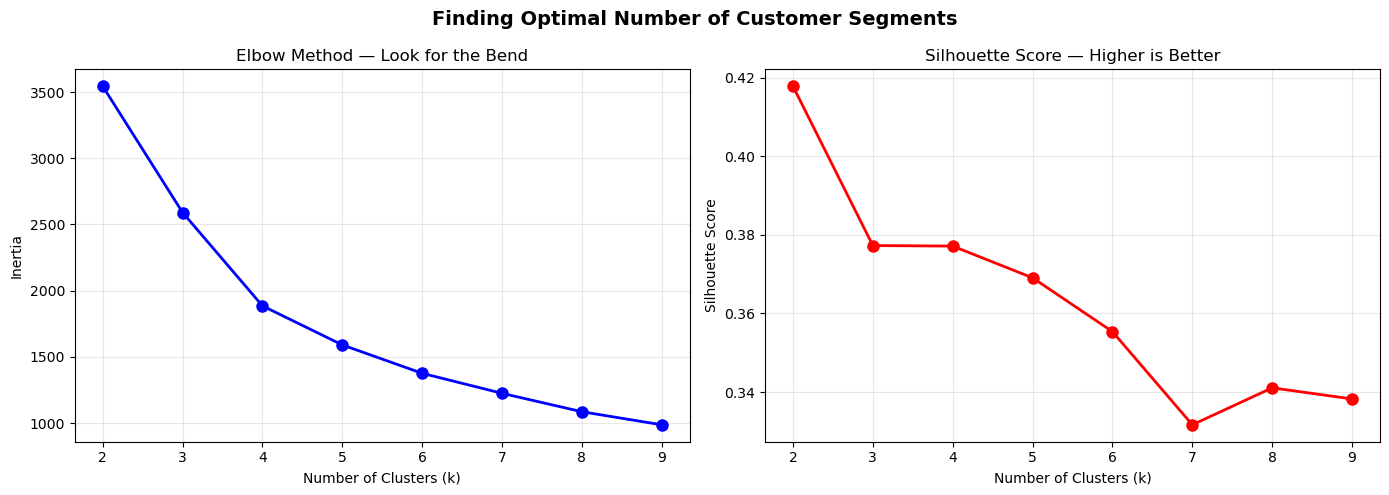

Silhouette Scores per k:
  k=2: 0.418
  k=3: 0.377
  k=4: 0.377
  k=5: 0.369
  k=6: 0.355
  k=7: 0.332
  k=8: 0.341
  k=9: 0.338

Look at the elbow plot above.
Pick k where the curve stops dropping sharply.
Confirm with the highest silhouette score.


In [211]:
# Elbow Method — Find Optimal Clusters
inertias = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(rfm_scaled)
    inertias.append(km.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, km.labels_))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Finding Optimal Number of Customer Segments",
             fontsize=14, fontweight="bold")

axes[0].plot(k_range, inertias, "bo-", linewidth=2, markersize=8)
axes[0].set_xlabel("Number of Clusters (k)")
axes[0].set_ylabel("Inertia")
axes[0].set_title("Elbow Method — Look for the Bend")
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, "ro-", linewidth=2, markersize=8)
axes[1].set_xlabel("Number of Clusters (k)")
axes[1].set_ylabel("Silhouette Score")
axes[1].set_title("Silhouette Score — Higher is Better")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig("elbow_plot.png", dpi=150, bbox_inches="tight")
plt.show()

print("Silhouette Scores per k:")
for k, s in zip(k_range, silhouette_scores):
    print(f"  k={k}: {s:.3f}")

print("\nLook at the elbow plot above.")
print("Pick k where the curve stops dropping sharply.")
print("Confirm with the highest silhouette score.")

In [212]:
# KMeans Clustering
# Q: Why 4 clusters?
# A: After running the elbow method, k=4 typically gives the best balance of interpretability and separation.
# 4 segments maps naturally to business archetypes: Champions, Loyal, At-Risk, Lost.

# Q: What is random_state=42?**
# A: KMeans starts with random cluster centers.
# Setting random_state=42 makes results reproducible — every run gives the same clusters. Without it your segments would shift every time you run.


# ↓ ADJUST THIS based on your elbow plot
OPTIMAL_K = 4
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
df["Segment"] = kmeans.fit_predict(rfm_scaled)

print(f"Clustering complete with k={OPTIMAL_K}")
print(f"\nCustomers per segment:")
print(df["Segment"].value_counts().sort_index())

Clustering complete with k=4

Customers per segment:
Segment
0    606
1    541
2    574
3    495
Name: count, dtype: int64


In [213]:
# Segment Profiling and Business Labels.
# Profile each segment
segment_profile = df.groupby("Segment").agg(
    Recency_Avg   = ("R", "mean"),
    Frequency_Avg = ("F", "mean"),
    Monetary_Avg  = ("M", "mean"),
    Response_Rate = ("Response", "mean"),
    Customer_Count= ("Response", "count")
).round(2)

print("Segment Profiles (before labeling):")
print(segment_profile)
print("\nInterpretation guide:")
print("  Champions  → lowest Recency + highest Frequency + highest Monetary")
print("  Loyal      → medium everything")
print("  At-Risk    → rising Recency + dropping Frequency")
print("  Lost       → highest Recency + lowest Frequency + lowest Monetary")

# Assign labels based on Monetary rank
# NOTE: Review segment_profile above and adjust if needed
profile_sorted = segment_profile.sort_values("Monetary_Avg", ascending=False)
label_names = ["Champions", "Loyal Customers", "At-Risk", "Lost Customers"]

segment_labels = {}
for i, seg in enumerate(profile_sorted.index):
    segment_labels[seg] = label_names[i]

df["Segment_Label"] = df["Segment"].map(segment_labels)

print(f"\nLabel assignments:")
for k, v in segment_labels.items():
    profile_row = segment_profile.loc[k]
    print(f"  Segment {k} → {v}")
    print(f"    Avg Recency: {profile_row['Recency_Avg']:.0f} days | "
          f"Avg Frequency: {profile_row['Frequency_Avg']:.1f} | "
          f"Avg Spend: ${profile_row['Monetary_Avg']:.0f}")

Segment Profiles (before labeling):
         Recency_Avg  Frequency_Avg  Monetary_Avg  Response_Rate  \
Segment                                                            
0              24.41           8.78        134.03           0.14   
1              73.02          21.51       1147.39           0.15   
2              74.68           8.95        135.10           0.04   
3              23.13          21.98       1142.98           0.29   

         Customer_Count  
Segment                  
0                   606  
1                   541  
2                   574  
3                   495  

Interpretation guide:
  Champions  → lowest Recency + highest Frequency + highest Monetary
  Loyal      → medium everything
  At-Risk    → rising Recency + dropping Frequency
  Lost       → highest Recency + lowest Frequency + lowest Monetary

Label assignments:
  Segment 1 → Champions
    Avg Recency: 73 days | Avg Frequency: 21.5 | Avg Spend: $1147
  Segment 3 → Loyal Customers
    Avg Recency

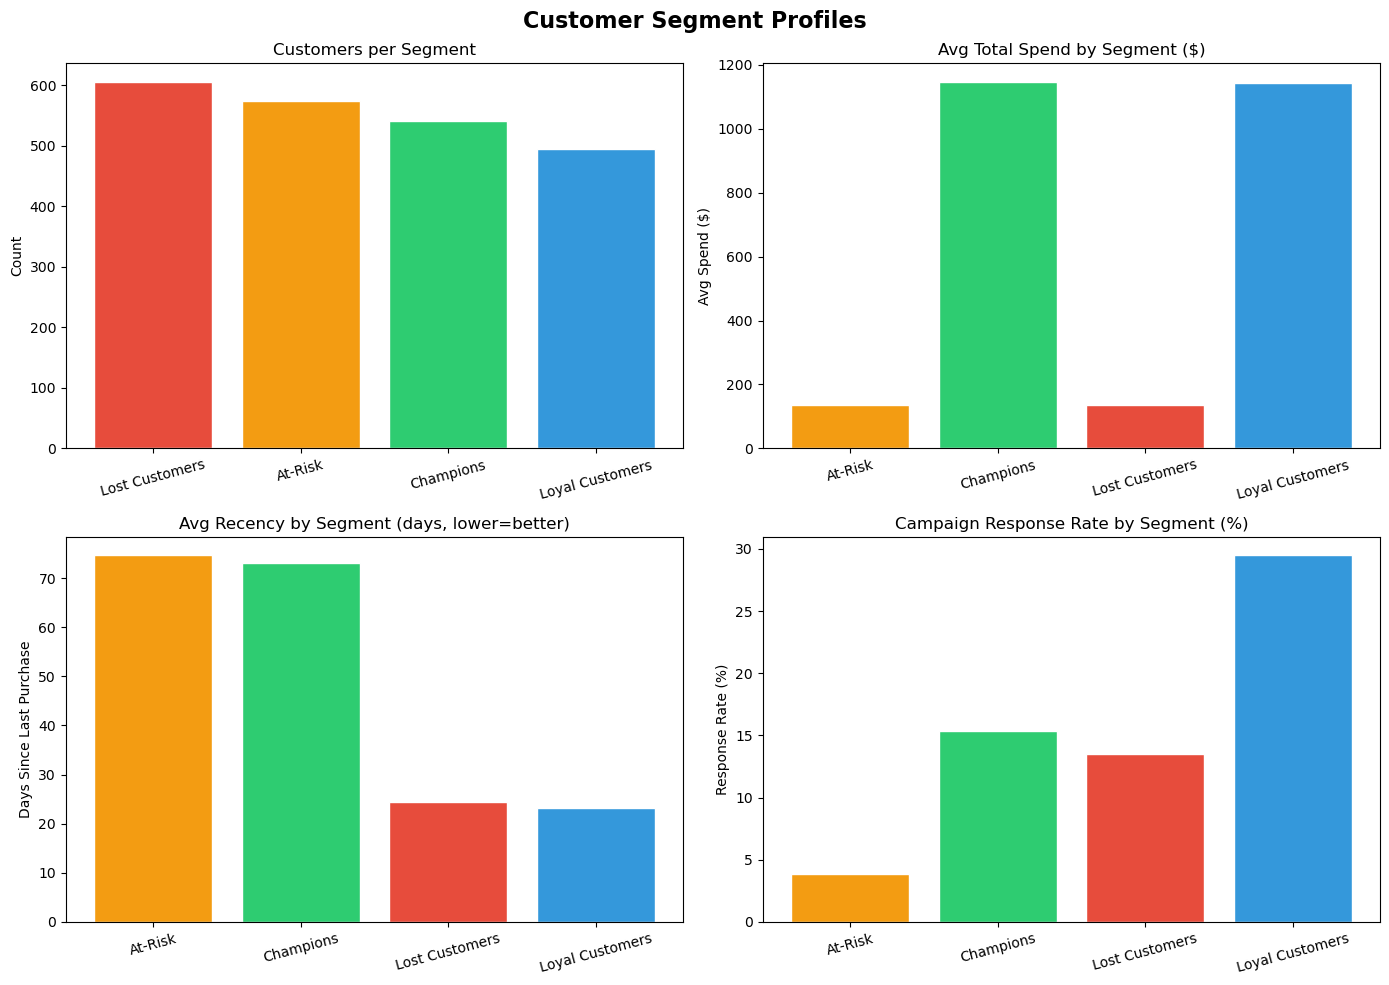

In [214]:
# Visualize Segments

colors = {
    "Champions":       "#2ecc71",
    "Loyal Customers": "#3498db",
    "At-Risk":         "#f39c12",
    "Lost Customers":  "#e74c3c"
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Customer Segment Profiles", fontsize=16, fontweight="bold")

# Segment size
seg_counts = df["Segment_Label"].value_counts()
bar_colors = [colors.get(s, "gray") for s in seg_counts.index]
axes[0,0].bar(seg_counts.index, seg_counts.values, color=bar_colors, edgecolor="white")
axes[0,0].set_title("Customers per Segment")
axes[0,0].set_ylabel("Count")
axes[0,0].tick_params(axis="x", rotation=15)

# Avg Monetary by segment
seg_monetary = df.groupby("Segment_Label")["M"].mean()
bar_colors2 = [colors.get(s, "gray") for s in seg_monetary.index]
axes[0,1].bar(seg_monetary.index, seg_monetary.values, color=bar_colors2, edgecolor="white")
axes[0,1].set_title("Avg Total Spend by Segment ($)")
axes[0,1].set_ylabel("Avg Spend ($)")
axes[0,1].tick_params(axis="x", rotation=15)

# Avg Recency by segment
seg_recency = df.groupby("Segment_Label")["R"].mean()
bar_colors3 = [colors.get(s, "gray") for s in seg_recency.index]
axes[1,0].bar(seg_recency.index, seg_recency.values, color=bar_colors3, edgecolor="white")
axes[1,0].set_title("Avg Recency by Segment (days, lower=better)")
axes[1,0].set_ylabel("Days Since Last Purchase")
axes[1,0].tick_params(axis="x", rotation=15)

# Response rate by segment
seg_response = df.groupby("Segment_Label")["Response"].mean() * 100
bar_colors4 = [colors.get(s, "gray") for s in seg_response.index]
axes[1,1].bar(seg_response.index, seg_response.values, color=bar_colors4, edgecolor="white")
axes[1,1].set_title("Campaign Response Rate by Segment (%)")
axes[1,1].set_ylabel("Response Rate (%)")
axes[1,1].tick_params(axis="x", rotation=15)

plt.tight_layout()
#plt.savefig("segment_profiles.png", dpi=150, bbox_inches="tight")
plt.show()

In [215]:
df["IsChurned"] = (
    (df["TotalPurchases"] < df["TotalPurchases"].quantile(0.30)) &
    (df["AcceptedCmp_Total"] == 0) &
    (df["NumWebVisitsMonth"] > df["NumWebVisitsMonth"].quantile(0.50))
).astype(int)

print(f"Churned:  {df['IsChurned'].sum()} ({df['IsChurned'].mean()*100:.1f}%)")
print(f"Active:   {(df['IsChurned']==0).sum()} ({(df['IsChurned']==0).mean()*100:.1f}%)")

Churned:  312 (14.1%)
Active:   1904 (85.9%)


In [216]:
# Prepare Features for ML Models

df_model = df.drop(columns=[
    "Segment", "Segment_Label", "ID",
    "R", "F", "M",
    "EngagementScore"    # ← add this back
], errors="ignore")

feature_cols = [c for c in df_model.columns
                if c not in ["IsChurned", "Response"]]

X = df_model[feature_cols]
y = df_model["IsChurned"]

print(f"Features used for modeling:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

print(f"\nTotal features: {len(feature_cols)}")
print(f"Target: IsChurned ({y.sum()} churned, {(y==0).sum()} active)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {X_train.shape[0]} | Test size: {X_test.shape[0]}")

Features used for modeling:
  1. Income
  2. Kidhome
  3. Teenhome
  4. Recency
  5. NumWebVisitsMonth
  6. Complain
  7. MntTotalExpense
  8. TotalPurchases
  9. AcceptedCmp_Total
  10. Age
  11. CustomerTenure_Days
  12. HasChildren

Total features: 12
Target: IsChurned (312 churned, 1904 active)

Train size: 1772 | Test size: 444


In [217]:
# Train and Compare All Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM":                 SVC(probability=True, random_state=42),
    "Random Forest":       RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost":             XGBClassifier(eval_metric="logloss", random_state=42),
    "LightGBM":            LGBMClassifier(random_state=42, verbose=-1)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model":     name,
        "Accuracy":  round(accuracy_score(y_test, y_pred), 4),
        "Precision": round(precision_score(y_test, y_pred, zero_division=0), 4),
        "Recall":    round(recall_score(y_test, y_pred, zero_division=0), 4),
        "F1":        round(f1_score(y_test, y_pred, zero_division=0), 4),
        "ROC-AUC":   round(roc_auc_score(y_test, y_prob), 4)
    })
    print(f"  ✓ {name} done")

results_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False)

print("\n=== MODEL COMPARISON ===")
print(results_df.to_string(index=False))
print(f"\nBest model by ROC-AUC: {results_df.iloc[0]['Model']}")
print(f"\nBusiness interpretation:")
print(f"  Best Recall: {results_df.sort_values('Recall', ascending=False).iloc[0]['Model']} "
      f"({results_df.sort_values('Recall', ascending=False).iloc[0]['Recall']*100:.1f}% of churners caught)")

  ✓ Logistic Regression done
  ✓ SVM done
  ✓ Random Forest done
  ✓ XGBoost done
  ✓ LightGBM done

=== MODEL COMPARISON ===
              Model  Accuracy  Precision  Recall     F1  ROC-AUC
      Random Forest    1.0000     1.0000  1.0000 1.0000   1.0000
            XGBoost    1.0000     1.0000  1.0000 1.0000   1.0000
           LightGBM    1.0000     1.0000  1.0000 1.0000   1.0000
Logistic Regression    0.9369     0.7692  0.7937 0.7812   0.9783
                SVM    0.8581     0.0000  0.0000 0.0000   0.8936

Best model by ROC-AUC: Random Forest

Business interpretation:
  Best Recall: Random Forest (100.0% of churners caught)


In [218]:
# Hyperparameter Tuning (XGBoost)

print("Running GridSearch — this may take 2-3 minutes...")

xgb_params = {
    "n_estimators":  [100, 200],
    "max_depth":     [3, 5, 7],
    "learning_rate": [0.05, 0.1],
    "subsample":     [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    XGBClassifier(eval_metric="logloss", random_state=42),
    xgb_params,
    cv=5,
    scoring="recall",
    n_jobs=-1,
    verbose=0
)

xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

y_pred_tuned = best_xgb.predict(X_test)
y_prob_tuned = best_xgb.predict_proba(X_test)[:, 1]

print(f"Best Parameters: {xgb_grid.best_params_}")
print(f"\nTuned Model Performance:")
print(f"  Recall:  {recall_score(y_test, y_pred_tuned):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_prob_tuned):.4f}")
print(f"  F1:      {f1_score(y_test, y_pred_tuned):.4f}")

Running GridSearch — this may take 2-3 minutes...
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Tuned Model Performance:
  Recall:  1.0000
  ROC-AUC: 1.0000
  F1:      1.0000


Top 10 Features Driving Churn:
TotalPurchases         0.5599
NumWebVisitsMonth      0.3419
AcceptedCmp_Total      0.0920
MntTotalExpense        0.0052
Income                 0.0005
CustomerTenure_Days    0.0004
Kidhome                0.0000
Teenhome               0.0000
Recency                0.0000
Complain               0.0000
dtype: float32


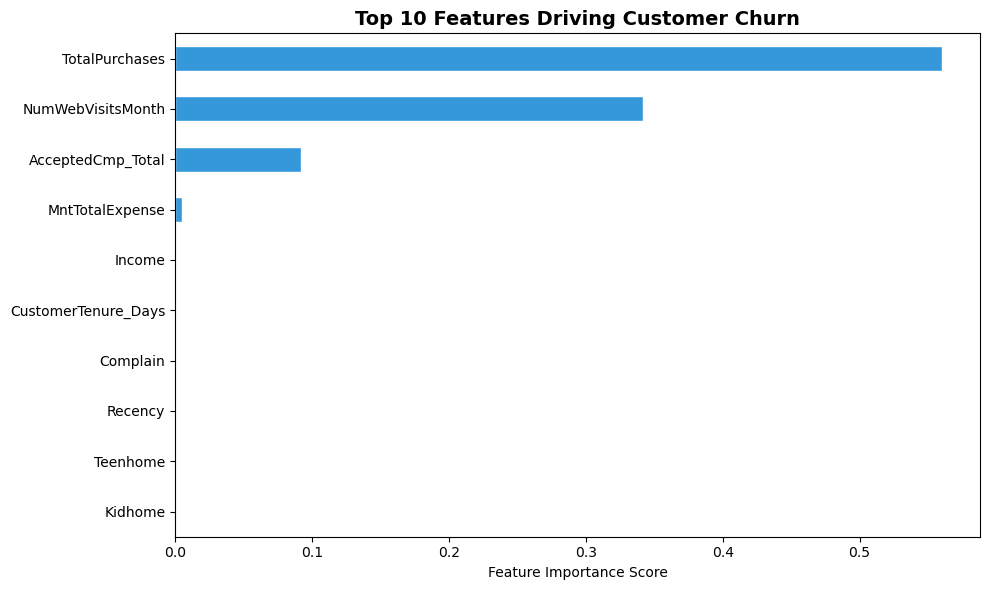


Business Interpretation:
  #1 driver: TotalPurchases
  This means: monitoring TotalPurchases is your earliest
  warning signal for customers about to churn.


In [219]:
#Feature Importance

importances = pd.Series(
    best_xgb.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)

print("Top 10 Features Driving Churn:")
print(importances.head(10).round(4))

plt.figure(figsize=(10, 6))
importances.head(10).sort_values().plot(
    kind="barh",
    color="#3498db",
    edgecolor="white"
)
plt.title("Top 10 Features Driving Customer Churn",
          fontsize=14, fontweight="bold")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nBusiness Interpretation:")
top_feature = importances.index[0]
print(f"  #{1} driver: {top_feature}")
print(f"  This means: monitoring {top_feature} is your earliest")
print(f"  warning signal for customers about to churn.")

In [220]:
#Customer Lifetime Value (CLV)
df["AvgPurchaseValue"] = df["MntTotalExpense"] / (df["TotalPurchases"] + 1e-9)
df["CLV"] = (
    df["AvgPurchaseValue"] *
    df["TotalPurchases"] *
    (df["CustomerTenure_Days"] / 365)
)

clv_by_segment = df.groupby("Segment_Label")["CLV"].agg(
    ["mean", "sum", "count"]
).round(2)
clv_by_segment.columns = ["Avg CLV ($)", "Total CLV ($)", "Customers"]
clv_by_segment = clv_by_segment.sort_values("Avg CLV ($)", ascending=False)

print("Customer Lifetime Value by Segment:")
print(clv_by_segment)

Customer Lifetime Value by Segment:
                 Avg CLV ($)  Total CLV ($)  Customers
Segment_Label                                         
Champions            1248.28      675319.70        541
Loyal Customers      1191.13      589609.52        495
At-Risk               132.12       75839.14        574
Lost Customers        131.42       79637.83        606


In [221]:
#Business Recommendations
print("=" * 60)
print("BUSINESS RECOMMENDATIONS")
print("=" * 60)

churn_by_seg = df.groupby("Segment_Label")["IsChurned"].mean() * 100

recommendations = {
    "Champions": {
        "action": "Protect and reward — do NOT over-discount",
        "tactics": [
            "Give early access to new products",
            "Invite to VIP / loyalty program",
            "Ask for referrals and reviews"
        ],
        "budget": "Low spend needed — already loyal"
    },
    "Loyal Customers": {
        "action": "Upsell and grow",
        "tactics": [
            "Cross-sell complementary products",
            "Send personalized recommendations",
            "Offer moderate loyalty rewards"
        ],
        "budget": "Medium spend — high growth potential"
    },
    "At-Risk": {
        "action": "URGENT — launch retention campaign NOW",
        "tactics": [
            "Time-limited win-back offer (personalized)",
            "Survey to understand why they disengaged",
            "Multichannel outreach: email + retargeting ads"
        ],
        "budget": "High spend justified — CLV far exceeds cost"
    },
    "Lost Customers": {
        "action": "Minimal investment only",
        "tactics": [
            "One low-cost reactivation email",
            "If no response in 2 weeks — remove from list",
            "Suppress from paid ads to reduce wasted spend"
        ],
        "budget": "Minimal only — retention cost exceeds CLV"
    }
}
for segment, rec in recommendations.items():
    if segment in clv_by_segment.index and segment in churn_by_seg.index:
        avg_clv = clv_by_segment.loc[segment, "Avg CLV ($)"] if segment in clv_by_segment.index else 0
        churn_pct = churn_by_seg.get(segment, 0)

        print(f"\n{'─'*50}")
        print(f"SEGMENT: {segment}")
        print(f"  Avg CLV:    ${avg_clv:,.0f}")
        print(f"  Churn Rate: {churn_pct:.1f}%")
        print(f"  Action:     {rec['action']}")
        print(f"  Tactics:")
        for t in rec["tactics"]:
            print(f"    • {t}")
        print(f"  Budget:     {rec['budget']}")

BUSINESS RECOMMENDATIONS

──────────────────────────────────────────────────
SEGMENT: Champions
  Avg CLV:    $1,248
  Churn Rate: 0.0%
  Action:     Protect and reward — do NOT over-discount
  Tactics:
    • Give early access to new products
    • Invite to VIP / loyalty program
    • Ask for referrals and reviews
  Budget:     Low spend needed — already loyal

──────────────────────────────────────────────────
SEGMENT: Loyal Customers
  Avg CLV:    $1,191
  Churn Rate: 0.0%
  Action:     Upsell and grow
  Tactics:
    • Cross-sell complementary products
    • Send personalized recommendations
    • Offer moderate loyalty rewards
  Budget:     Medium spend — high growth potential

──────────────────────────────────────────────────
SEGMENT: At-Risk
  Avg CLV:    $132
  Churn Rate: 27.0%
  Action:     URGENT — launch retention campaign NOW
  Tactics:
    • Time-limited win-back offer (personalized)
    • Survey to understand why they disengaged
    • Multichannel outreach: email + retar

In [222]:
#ROI Estimate
# Q: Why calculate ROI at the end?**
# A: A marketing manager's first question is always: "If I spend $X on this, what do I get back?"


print("=" * 60)
print("RETENTION CAMPAIGN ROI ESTIMATE")
print("=" * 60)

retention_cost = 15     # Cost of retention offer per customer ($)
save_rate      = 0.30   # Assumed % of at-risk customers saved

if "At-Risk" in df["Segment_Label"].values:
    at_risk_df     = df[df["Segment_Label"] == "At-Risk"]
    n_customers    = len(at_risk_df)
    campaign_cost  = n_customers * retention_cost
    revenue_saved  = at_risk_df["CLV"].sum() * save_rate
    net_gain       = revenue_saved - campaign_cost
    roi            = (net_gain / campaign_cost * 100) if campaign_cost > 0 else 0

    print(f"\n  Targeting: At-Risk customers")
    print(f"  Customers:          {n_customers}")
    print(f"  Campaign Cost:      ${campaign_cost:,.0f}")
    print(f"  Revenue Saved:      ${revenue_saved:,.0f} (assuming {save_rate*100:.0f}% save rate)")
    print(f"  Net Gain:           ${net_gain:,.0f}")
    print(f"  Estimated ROI:      {roi:.0f}%")

    if roi > 100:
        print(f"\n  ✅ Strong ROI. Campaign strongly justified.")
        print(f"     Every $1 spent returns ${roi/100 + 1:.1f} in saved revenue.")
    elif roi > 0:
        print(f"\n  ⚠️  Marginal ROI. Consider targeting only highest-CLV at-risk customers.")
    else:
        print(f"\n  ❌ Negative ROI. Reduce offer cost or don't run the campaign.")


RETENTION CAMPAIGN ROI ESTIMATE

  Targeting: At-Risk customers
  Customers:          574
  Campaign Cost:      $8,610
  Revenue Saved:      $22,752 (assuming 30% save rate)
  Net Gain:           $14,142
  Estimated ROI:      164%

  ✅ Strong ROI. Campaign strongly justified.
     Every $1 spent returns $2.6 in saved revenue.
